In [1]:
import csv
import sklearn

import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import umap.umap_ as umap
from scipy.linalg import eigh as largest_eigh
from scipy.linalg import orthogonal_procrustes

In [1]:
HiC_Exc = pd.read_csv("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/SAI_results/single_cell_eigens/Exc/eigen.txt", sep='\t', names=["chr", "start", "end", "compartment", "eigen"], index_col=False)
bin_df = pd.read_csv("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/gap.blacklist.hg38.1000000.4col.autosomal.bed", sep='\t', names=["chr","start","end","name"])
delete_bins = np.load("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/Cross-Sample/1000K_resolution/delete_bins.npy")
bin_df_new = bin_df.drop(delete_bins).reset_index(drop=True)
CON_Exc_feature = np.load("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/Cross-Sample/1000K_resolution/3_CON/cell_type/Exc/raw/feature.npy")
PTSD_Exc_feature = np.load("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/Cross-Sample/1000K_resolution/2_PTSD/cell_type/Exc/raw/feature.npy")

NameError: name 'pd' is not defined

In [3]:
bin_df_new.loc[228,:]

chr          chr2
start    15000000
end      16000000
name      chr2_16
Name: 228, dtype: object

In [110]:
bin_df_new[bin_df_new.name=="chr8_85"]

,chr,start,end,name
1220,chr8,84000000,85000000,chr8_85


In [4]:
bin_df_new[bin_df_new.chr=="chr2"]

,chr,start,end,name
218,chr2,0,1000000,chr2_1
219,chr2,2000000,3000000,chr2_3
220,chr2,5000000,6000000,chr2_6
221,chr2,6000000,7000000,chr2_7
222,chr2,7000000,8000000,chr2_8
...,...,...,...,...
417,chr2,233000000,234000000,chr2_234
418,chr2,235000000,236000000,chr2_236
419,chr2,236000000,237000000,chr2_237
420,chr2,237000000,238000000,chr2_238


In [6]:
chr_start = 218
chr_end = 421
key_point = 228 - chr_start
metacell = 200

Ast
17296.867151607963 12816.22238514174


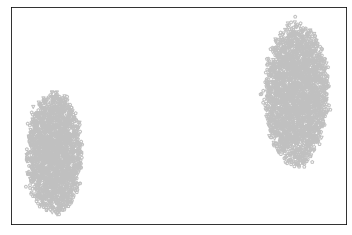

End
1767.4760828625235 2721.690963554668


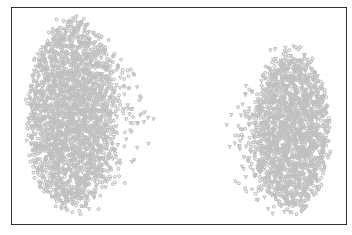

Exc
69407.53604781472 110322.4305906108


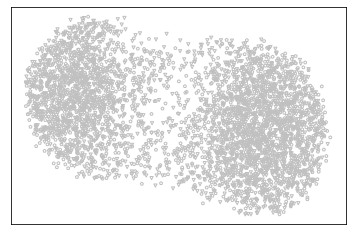

Inh
18223.84231756509 26385.828068358365


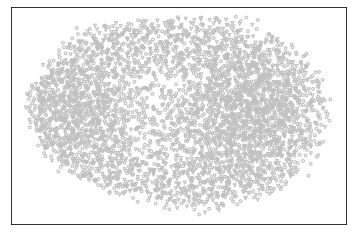

Mic
5691.563022157647 11365.716010498687


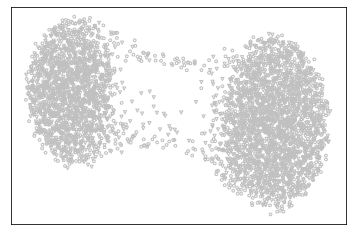

Olig
16936.186139332367 36636.41324921136


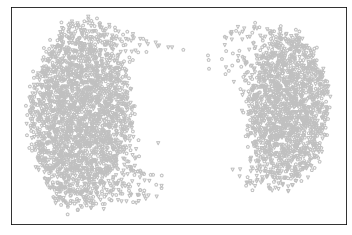

OPC
5380.718436873747 9856.37920673077


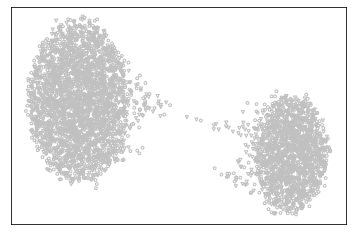

In [20]:
chr_start = 218
chr_end = 421
key_point = 228 - chr_start
metacell = 200

for cell_type in ["Ast", "End", "Exc", "Inh", "Mic", "Olig", "OPC"]:
# for cell_type in ["Exc"]:
    
    print(cell_type)
    
    CON_emb = np.load("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/Cross-Sample/1000K_resolution/3_CON/cell_type/"+cell_type+"/"+str(metacell)+"_metacell/Embedding/corr_0_1_VERSE_32.npy")
    MDD_emb = np.load("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/Cross-Sample/1000K_resolution/2_MDD/cell_type/"+cell_type+"/"+str(metacell)+"_metacell/Embedding/corr_0_1_VERSE_32.npy")
    PTSD_emb = np.load("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/Cross-Sample/1000K_resolution/2_PTSD/cell_type/"+cell_type+"/"+str(metacell)+"_metacell/Embedding/corr_0_1_VERSE_32.npy")
    
    CON_feature = np.load("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/Cross-Sample/1000K_resolution/3_CON/cell_type/"+cell_type+"/raw/feature.npy")
    MDD_feature = np.load("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/Cross-Sample/1000K_resolution/2_MDD/cell_type/"+cell_type+"/raw/feature.npy")
    PTSD_feature = np.load("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/Cross-Sample/1000K_resolution/2_PTSD/cell_type/"+cell_type+"/raw/feature.npy")
    
    R, _ = orthogonal_procrustes(PTSD_emb, CON_emb)
    transfer_PTSD_emb = PTSD_emb @ R

    R, _ = orthogonal_procrustes(MDD_emb, CON_emb)
    transfer_MDD_emb = MDD_emb @ R
    
#     embedding = np.vstack((CON_emb, transfer_PTSD_emb))
    embedding = np.vstack((CON_emb, transfer_MDD_emb))
    # embedding = CON_emb
    adata = ad.AnnData(embedding)
    sc.pp.neighbors(adata, n_neighbors=100, use_rep='X')
    sc.tl.leiden(adata,resolution=0.5)
    sc.tl.umap(adata)
    # adata.obs['eigen'] = np.vstack((CON_Exc_eigen, PTSD_Exc_eigen))
#     fig = sc.pl.umap(adata, color='leiden', return_fig=True)
    # fig = sc.pl.umap(adata, color='eigen', return_fig=True)
    # fig.savefig('before_alignment.eps',dpi=1000,format='eps')
#     plt.show()
    
    pos = np.array(adata.obsm['X_umap'])
    color_array = np.array(adata.obs["leiden"], dtype=np.int32)
    total_feature = np.hstack((np.sum(CON_feature, axis=0), np.sum(PTSD_feature, axis=0)))
    
    print(np.mean(total_feature[np.where(color_array==0)]),np.mean(total_feature[np.where(color_array==1)]))
    
    color_list = []
    size_list = []
    linewidths_list = []


    for i in range(color_array.shape[0]):
        if (i>=chr_start and i<chr_end) or (i>=chr_start+2329 and i<chr_end+2329):
            size_list.append(70)
            linewidths_list.append(2)
            if color_array[i] == 1:
                color_list.append("#ad5247")
            else:
                color_list.append("#6e896a")
        else:
            size_list.append(5)
            linewidths_list.append(1)
            color_list.append("#C0C0C0")
            
    edgecolors_list = color_list
    non_color_list = ['none' for i in range(color_array.shape[0])]
    

    show_background = True
#     show_background = False
    for i in range(color_array.shape[0]):
        if i<2329:
            if show_background:
                if i==chr_start+key_point:
                    pass
                elif (i>=chr_start and i<chr_end):
                    pass
                else:
                    plt.scatter(pos[i,0], pos[i,1], s=10, color=non_color_list[i], marker="p", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])
            else:
                if i==chr_start+key_point:
                    print(i,edgecolors_list[i], pos[i,0], pos[i,1])
                    plt.scatter(pos[i,0], pos[i,1], s=1000, color=edgecolors_list[i], marker="p", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])
                elif (i>=chr_start and i<chr_end):
                    plt.scatter(pos[i,0], pos[i,1], s=30, color=non_color_list[i], marker="p", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])
                else:
                    pass
        else:
            if show_background:
                if i==chr_start+key_point+2329:
                    pass
                elif (i>=chr_start+2329 and i<chr_end+2329):
                    pass
                else:
                    plt.scatter(pos[i,0], pos[i,1], s=10, color=non_color_list[i], marker="v", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i]) 
            else:
                if i==chr_start+key_point+2329:
                    print(i,edgecolors_list[i], pos[i,0], pos[i,1])
                    plt.scatter(pos[i,0], pos[i,1], s=1000, color=edgecolors_list[i], marker="v", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])
                elif (i>=chr_start+2329 and i<chr_end+2329):
                    plt.scatter(pos[i,0], pos[i,1], s=30, color=non_color_list[i], marker="v", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])
                else:
                    pass
    # plt.scatter(pos[:,0], pos[:,1], s=size_list, color=non_color_list, marker="o", edgecolors=edgecolors_list, linewidths=linewidths_list)
    # plt.savefig('CON_Exc_chr10.eps',dpi=1000,format='eps')
    # plt.savefig('CON_Exc_background_chr10.eps',dpi=1000,format='eps')
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    if show_background:
        plt.savefig("./Figure6/"+cell_type+'background.eps',dpi=1000,format='eps')
    else:
        plt.savefig("./Figure6/"+cell_type+'_target.eps',dpi=1000,format='eps')
    plt.show()

In [4]:
CON_Exc_corr = np.load("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/Cross-Sample/1000K_resolution/3_CON/cell_type/Exc/raw/Matrix/corr.npy")
MDD_Exc_corr = np.load("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/Cross-Sample/1000K_resolution/2_MDD/cell_type/Exc/raw/Matrix/corr.npy")
PTSD_Exc_corr = np.load("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/Cross-Sample/1000K_resolution/2_PTSD/cell_type/Exc/raw/Matrix/corr.npy")

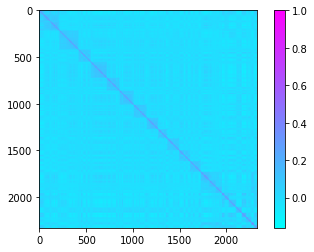

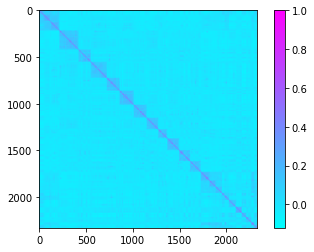

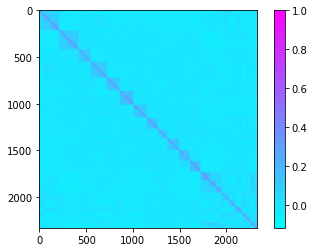

In [5]:
plt.imshow(CON_Exc_corr, cmap=plt.cm.cool)
plt.colorbar()
plt.show()
plt.imshow(MDD_Exc_corr, cmap=plt.cm.cool)
plt.colorbar()
plt.show()
plt.imshow(PTSD_Exc_corr, cmap=plt.cm.cool)
plt.colorbar()
plt.show()

In [6]:
delta_corr = np.abs(CON_Exc_corr - MDD_Exc_corr)
# delta_corr = np.abs(CON_Exc_corr - PTSD_Exc_corr)
delta_corr_list = np.sum(delta_corr, axis=1)
sort_list = np.argsort(delta_corr_list)

In [7]:
delta_corr_list[1273]

39.250081926811205

In [8]:
delta_corr_list[2318]

93.17986028009942

In [9]:
sort_list

array([1273,  118, 2320, ..., 1106, 1110, 2318])

In [10]:
delta_corr.shape

(2329, 2329)

In [14]:
delta_corr_list

array([55.07814215, 50.29871668, 49.02062357, ..., 60.94140898,
       51.08822922, 53.48096486])

In [11]:
chr_list = []
chr_corr_diff_list = []
for i in range(delta_corr.shape[0]):
    if sort_list[i]>=chr_start and sort_list[i]<=chr_end:
        chr_list.append(sort_list[i])
        chr_corr_diff_list.append(delta_corr_list[sort_list[i]])

In [26]:
chr_list

[419,
 417,
 416,
 405,
 407,
 359,
 406,
 252,
 420,
 250,
 356,
 414,
 358,
 418,
 310,
 408,
 403,
 278,
 415,
 402,
 254,
 386,
 292,
 362,
 309,
 385,
 308,
 316,
 260,
 256,
 307,
 366,
 360,
 238,
 357,
 299,
 325,
 365,
 381,
 364,
 378,
 297,
 413,
 284,
 298,
 411,
 286,
 324,
 404,
 384,
 320,
 280,
 249,
 311,
 259,
 302,
 295,
 257,
 379,
 304,
 389,
 277,
 330,
 223,
 296,
 410,
 383,
 409,
 282,
 255,
 352,
 367,
 361,
 288,
 241,
 390,
 279,
 289,
 220,
 243,
 306,
 251,
 262,
 281,
 318,
 315,
 237,
 329,
 242,
 363,
 350,
 346,
 355,
 323,
 287,
 275,
 218,
 401,
 314,
 398,
 312,
 303,
 399,
 382,
 305,
 285,
 349,
 271,
 351,
 294,
 283,
 267,
 270,
 258,
 253,
 248,
 232,
 388,
 239,
 261,
 221,
 263,
 353,
 222,
 354,
 319,
 376,
 380,
 412,
 269,
 247,
 335,
 272,
 377,
 391,
 300,
 348,
 236,
 234,
 328,
 374,
 290,
 268,
 244,
 227,
 400,
 332,
 231,
 321,
 228,
 240,
 322,
 291,
 276,
 333,
 313,
 317,
 345,
 274,
 342,
 301,
 387,
 224,
 375,
 338,
 266,
 347

In [12]:
chr_list.index(key_point+chr_start), chr_list[0]

(149, 419)

In [13]:
length = chr_end - chr_start

avg_20=0
for i in range(int(0.2*length)):
    avg_20 += delta_corr[chr_list[i],chr_start:chr_end+1].reshape(1,-1)
avg_20 = avg_20/int(0.2*length)
    
avg_40=0
for i in range(int(0.4*length)):
    avg_40 += delta_corr[chr_list[i],chr_start:chr_end+1].reshape(1,-1)
avg_40 = avg_40/int(0.4*length)
    
avg_60=0
for i in range(int(0.6*length)):
    avg_60 += delta_corr[chr_list[i],chr_start:chr_end+1].reshape(1,-1)
avg_60 = avg_60/int(0.6*length)
    
avg_80=0
for i in range(int(0.8*length)):
    avg_80 += delta_corr[chr_list[i],chr_start:chr_end+1].reshape(1,-1)
avg_80 = avg_80/int(0.8*length)
    
avg_100=0
for i in range(int(1*length)):
    avg_100 += delta_corr[chr_list[i],chr_start:chr_end+1].reshape(1,-1)
avg_100 = avg_100/int(1*length)

In [14]:
delta_corr.shape

(2329, 2329)

In [15]:
data = np.concatenate((delta_corr[key_point+chr_start,chr_start:chr_end+1].reshape(1,-1), avg_100, avg_80, avg_60, avg_40, avg_20, delta_corr[chr_list[0],chr_start:chr_end+1].reshape(1,-1)), axis=0)

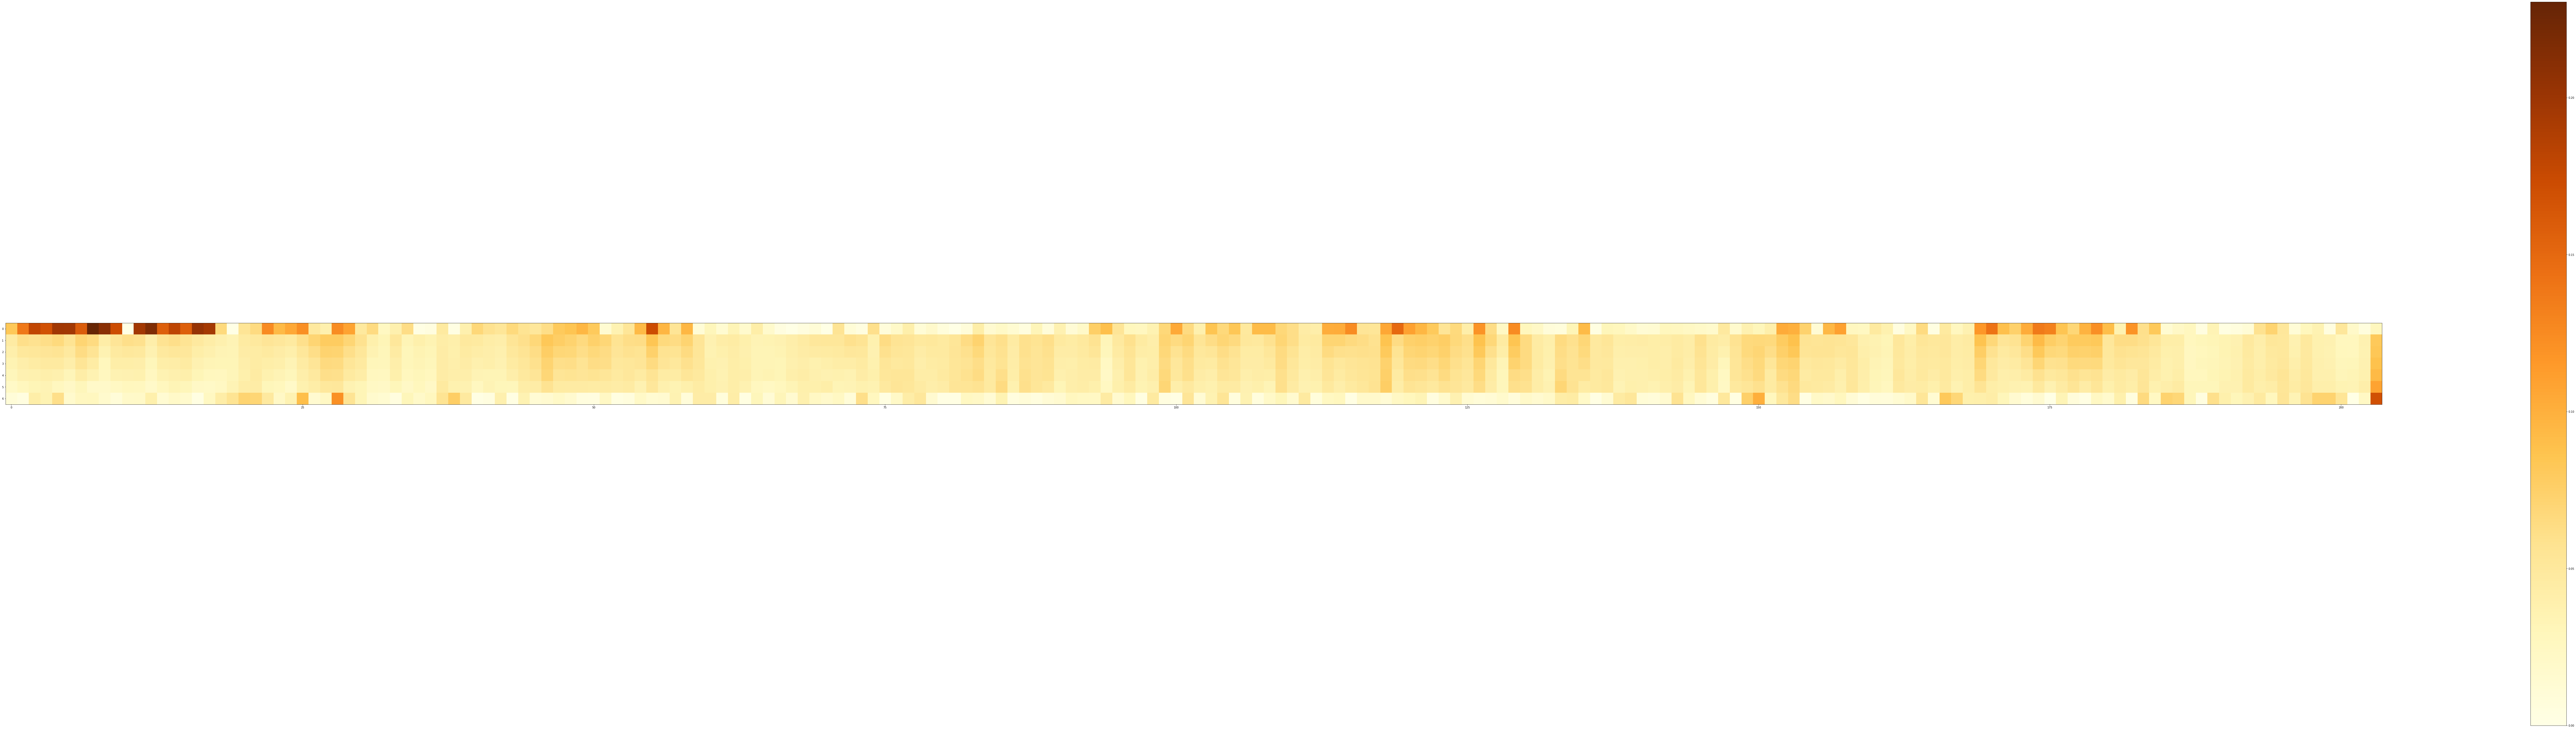

In [17]:
plt.figure(figsize=(200,50))
plt.imshow(data, cmap='YlOrBr')
plt.colorbar()
plt.savefig("./Figure6/heatmap_chr2_20_40_60_80_100.eps",format="eps")
plt.show()

In [411]:
cell_type = "Ast"
# cell_type = "End"
# cell_type = "Exc"
# cell_type = "Inh"
# cell_type = "Mic"
# cell_type = "Olig"
# cell_type = "OPC"
CON_emb = np.load("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/Cross-Sample/1000K_resolution/3_CON/cell_type/"+cell_type+"/20_metacell/Embedding/corr_0_1_VERSE_32.npy")
MDD_emb = np.load("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/Cross-Sample/1000K_resolution/2_MDD/cell_type/"+cell_type+"/20_metacell/Embedding/corr_0_1_VERSE_32.npy")
PTSD_emb = np.load("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/Cross-Sample/1000K_resolution/2_PTSD/cell_type/"+cell_type+"/20_metacell/Embedding/corr_0_1_VERSE_32.npy")

In [412]:
CON_feature = np.load("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/Cross-Sample/1000K_resolution/3_CON/cell_type/"+cell_type+"/raw/feature.npy")
MDD_feature = np.load("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/Cross-Sample/1000K_resolution/2_MDD/cell_type/"+cell_type+"/raw/feature.npy")
PTSD_feature = np.load("/lv_scratch/scratch/share/scENCORE_brain/ZD_SS_ShareData/Cross-Sample/1000K_resolution/2_PTSD/cell_type/"+cell_type+"/raw/feature.npy")

In [413]:
R, _ = orthogonal_procrustes(PTSD_emb, CON_emb)
transfer_PTSD_emb = PTSD_emb @ R

R, _ = orthogonal_procrustes(MDD_emb, CON_emb)
transfer_MDD_emb = MDD_emb @ R

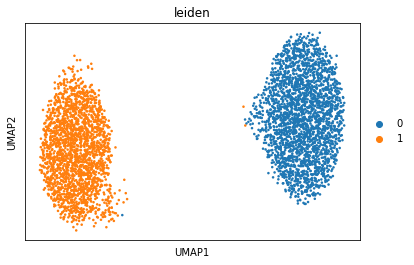

In [414]:
embedding = np.vstack((CON_emb, transfer_PTSD_emb))
# embedding = np.vstack((CON_emb, transfer_MDD_emb))
# embedding = CON_emb
adata = ad.AnnData(embedding)
sc.pp.neighbors(adata, n_neighbors=100, use_rep='X')
sc.tl.leiden(adata,resolution=0.5)
sc.tl.umap(adata)
# adata.obs['eigen'] = np.vstack((CON_Exc_eigen, PTSD_Exc_eigen))
fig = sc.pl.umap(adata, color='leiden', return_fig=True)
# fig = sc.pl.umap(adata, color='eigen', return_fig=True)
# fig.savefig('before_alignment.eps',dpi=1000,format='eps')

In [415]:
pos = np.array(adata.obsm['X_umap'])
color_array = np.array(adata.obs["leiden"], dtype=np.int32)
total_feature = np.hstack((np.sum(CON_feature, axis=0), np.sum(PTSD_feature, axis=0)))

In [416]:
np.mean(total_feature[np.where(color_array==0)]),np.mean(total_feature[np.where(color_array==1)])

(17612.413913719392, 12510.63165467626)

In [417]:
color_list = []
size_list = []
linewidths_list = []

chr_start = 552
chr_end = 723
for i in range(color_array.shape[0]):
    if (i>=chr_start and i<chr_end) or (i>=chr_start+2329 and i<chr_end+2329):
        size_list.append(70)
        linewidths_list.append(2)
        if color_array[i] == 1:
            color_list.append("#ad5247")
        else:
            color_list.append("#6e896a")
    else:
        size_list.append(5)
        linewidths_list.append(1)
        color_list.append("#C0C0C0")

557 #6e896a 10.501843 3.8175867
2886 #6e896a 13.752582 4.1652255


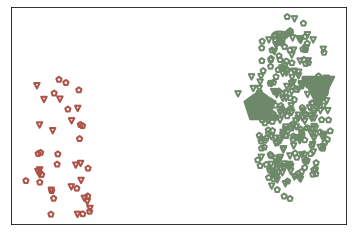

In [419]:
edgecolors_list = color_list
non_color_list = ['none' for i in range(color_array.shape[0])]
key_point = 557 - chr_start
            
# show_background = True
show_background = False
for i in range(color_array.shape[0]):
    if i<2329:
        if show_background:
            if i==chr_start+key_point:
                pass
            elif (i>=chr_start and i<chr_end):
                pass
            else:
                plt.scatter(pos[i,0], pos[i,1], s=10, color=non_color_list[i], marker="p", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])
        else:
            if i==chr_start+key_point:
                print(i,edgecolors_list[i], pos[i,0], pos[i,1])
                plt.scatter(pos[i,0], pos[i,1], s=1000, color=edgecolors_list[i], marker="p", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])
            elif (i>=chr_start and i<chr_end):
                plt.scatter(pos[i,0], pos[i,1], s=30, color=non_color_list[i], marker="p", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])
            else:
                pass
    else:
        if show_background:
            if i==chr_start+key_point+2329:
                pass
            elif (i>=chr_start+2329 and i<chr_end+2329):
                pass
            else:
                plt.scatter(pos[i,0], pos[i,1], s=10, color=non_color_list[i], marker="v", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i]) 
        else:
            if i==chr_start+key_point+2329:
                print(i,edgecolors_list[i], pos[i,0], pos[i,1])
                plt.scatter(pos[i,0], pos[i,1], s=1000, color=edgecolors_list[i], marker="v", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])
            elif (i>=chr_start+2329 and i<chr_end+2329):
                plt.scatter(pos[i,0], pos[i,1], s=30, color=non_color_list[i], marker="v", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])
            else:
                pass
# plt.scatter(pos[:,0], pos[:,1], s=size_list, color=non_color_list, marker="o", edgecolors=edgecolors_list, linewidths=linewidths_list)
# plt.savefig('CON_Exc_chr10.eps',dpi=1000,format='eps')
# plt.savefig('CON_Exc_background_chr10.eps',dpi=1000,format='eps')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
if show_background:
    plt.savefig('background.eps',dpi=1000,format='eps')
else:
    plt.savefig('target.eps',dpi=1000,format='eps')
plt.show()

In [ ]:
# edgecolors_list = color_list
# non_color_list = ['none' for i in range(color_array.shape[0])]
# key_point = 1997 - chr_start
            
# # show_background = True
# show_background = False
# for i in range(color_array.shape[0]):
#     if i<2329:
#         if show_background:
#             if i==chr_start+key_point:
#                 pass
#             elif (i>=chr_start and i<chr_end):
#                 pass
#             else:
#                 plt.scatter(pos[i,0], pos[i,1], s=10, color=non_color_list[i], marker="p", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])
#         else:
#             if i==chr_start+key_point:
#                 print(i,edgecolors_list[i], pos[i,0], pos[i,1])
#                 plt.scatter(pos[i,0], pos[i,1], s=1000, color=edgecolors_list[i], marker="p", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])
#             elif (i>=chr_start and i<chr_end):
#                 plt.scatter(pos[i,0], pos[i,1], s=30, color=non_color_list[i], marker="p", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])
#             else:
#                 pass
#     else:
#         if show_background:
#             if i==chr_start+key_point+2329:
#                 pass
#             elif (i>=chr_start+2329 and i<chr_end+2329):
#                 pass
#             else:
#                 plt.scatter(pos[i,0], pos[i,1], s=10, color=non_color_list[i], marker="*", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i]) 
#         else:
#             if i==chr_start+key_point+2329:
#                 print(i,edgecolors_list[i], pos[i,0], pos[i,1])
#                 plt.scatter(pos[i,0], pos[i,1], s=1000, color=edgecolors_list[i], marker="*", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])
#             elif (i>=chr_start+2329 and i<chr_end+2329):
#                 plt.scatter(pos[i,0], pos[i,1], s=30, color=non_color_list[i], marker="*", edgecolors=edgecolors_list[i], linewidths=linewidths_list[i])
#             else:
#                 pass
# # plt.scatter(pos[:,0], pos[:,1], s=size_list, color=non_color_list, marker="o", edgecolors=edgecolors_list, linewidths=linewidths_list)
# # plt.savefig('CON_Exc_chr10.eps',dpi=1000,format='eps')
# # plt.savefig('CON_Exc_background_chr10.eps',dpi=1000,format='eps')
# plt.gca().set_xticks([])
# plt.gca().set_yticks([])
# if show_background:
#     plt.savefig('background.eps',dpi=1000,format='eps')
# else:
#     plt.savefig('target.eps',dpi=1000,format='eps')
# plt.show()